<a href="https://colab.research.google.com/github/dcpatton/Structured-Data/blob/main/higgs_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import random

seed = 53
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)
# print('TensorFlow Datasets version = ' + tfds.__version__)

TensorFlow version = 2.8.2


In [2]:
# raw_ds = tfds.load('higgs', try_gcs=True, as_supervised=True, shuffle_files=True)
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [3]:
FEATURES = 28
raw_ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [4]:
num_features = 21
def pack_row(*row):
  label = row[0]
  # features = tf.stack(row[1:],1)
  features = tf.stack(row[1:num_features+1], 1)
  return features, label

In [5]:
packed_ds = raw_ds.batch(10000).map(pack_row).unbatch().shuffle(1024)

In [6]:
def do_eda(features, label):
  for feature in features:
    if feature == -999. :
      print('-999 found')
  return features, label


In [7]:
packed_ds = packed_ds.map(do_eda)

-999 found


In [8]:
DATASET_SIZE = 11000000
train_size = int(0.9 * DATASET_SIZE)
val_size = int(0.05 * DATASET_SIZE)
test_size = int(0.05 * DATASET_SIZE)

train_ds = packed_ds.take(train_size)
test_ds = packed_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

train_size, val_size, test_size

(9900000, 550000, 550000)

In [9]:
%%time
x_shape = train_ds.element_spec[0].shape
feature_ds = train_ds.map(lambda x, y: tf.reshape(x, x_shape)).batch(10000)
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(feature_ds)

Cause: could not parse the source code of <function <lambda> at 0x7fbd404f03b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fbd404f03b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 8min 26s, sys: 1min 26s, total: 9min 52s
Wall time: 6min


In [10]:
BATCH_SIZE = 4096
train_ds = train_ds.batch(BATCH_SIZE).shuffle(1024).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model

inp = Input(shape=(num_features,))
x = normalizer(inp)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
x = Dense(512, activation='swish')(x)
# x = Dropout(0.25)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp], outputs=[out])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 normalization (Normalizatio  (None, 21)               43        
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               11264     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                             

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.AUC()])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9, verbose=1, mode='auto', restore_best_weights=True)

history = model.fit(train_ds, epochs=200, verbose=2, callbacks=[es], validation_data=val_ds)

Epoch 1/200
2417/2417 - 538s - loss: 0.6407 - auc: 0.6750 - val_loss: 0.6271 - val_auc: 0.6975 - 538s/epoch - 223ms/step
Epoch 2/200
2417/2417 - 285s - loss: 0.6170 - auc: 0.7117 - val_loss: 0.6080 - val_auc: 0.7241 - 285s/epoch - 118ms/step
Epoch 3/200
2417/2417 - 282s - loss: 0.6019 - auc: 0.7320 - val_loss: 0.5944 - val_auc: 0.7414 - 282s/epoch - 117ms/step
Epoch 4/200
2417/2417 - 280s - loss: 0.5865 - auc: 0.7508 - val_loss: 0.5815 - val_auc: 0.7569 - 280s/epoch - 116ms/step
Epoch 5/200
2417/2417 - 275s - loss: 0.5756 - auc: 0.7630 - val_loss: 0.5730 - val_auc: 0.7666 - 275s/epoch - 114ms/step
Epoch 6/200
2417/2417 - 274s - loss: 0.5681 - auc: 0.7709 - val_loss: 0.5648 - val_auc: 0.7742 - 274s/epoch - 113ms/step
Epoch 7/200
2417/2417 - 276s - loss: 0.5622 - auc: 0.7770 - val_loss: 0.5606 - val_auc: 0.7786 - 276s/epoch - 114ms/step
Epoch 8/200
2417/2417 - 284s - loss: 0.5572 - auc: 0.7820 - val_loss: 0.5554 - val_auc: 0.7838 - 284s/epoch - 117ms/step
Epoch 9/200
2417/2417 - 281s - l

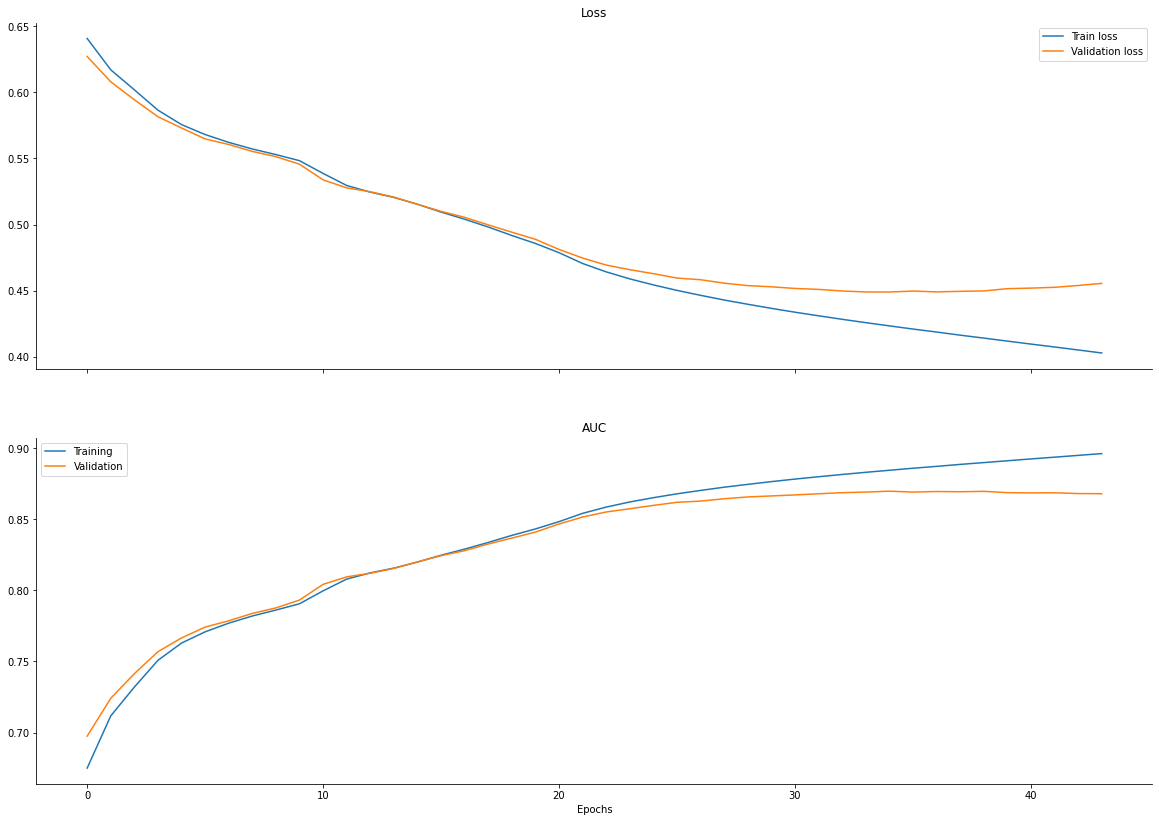

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auc'], label='Training')
ax2.plot(history['val_auc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('AUC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
model.evaluate(test_ds)

135/135 [==============================] - 278s 108ms/step - loss: 0.4478 - auc: 0.8709


[0.44781944155693054, 0.8709169626235962]

* baseline                   : loss: 0.4547 - auc: 0.8655
* normalization              : loss: 0.4542 - auc: 0.8655
* 21 features                : loss: 0.4595 - auc: 0.8625
* deeper network             : loss: 0.4479 - auc: 0.8697
* adjusted splits            : loss: 0.4445 - auc: 0.8722
* shuffle before split       : loss: 0.4445 - auc: 0.8723
* dropout 0.25               : loss: 0.4783 - auc: 0.8516
* lr=1e-4                    : loss: 0.4478 - auc: 0.8709

In [15]:
# y_pred = model.predict(test_ds)
y_pred = (model.predict(test_ds) > 0.5).astype(int)

In [16]:
y_true = []
for features, label in test_ds.unbatch().take(550000):
  y_true.append(label.numpy())
len(y_true)

550000

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.47      0.45      0.46    259026
         1.0       0.53      0.55      0.54    290974

    accuracy                           0.50    550000
   macro avg       0.50      0.50      0.50    550000
weighted avg       0.50      0.50      0.50    550000



In [18]:
num_t = 0
num_f = 0
for val in y_true:
  if val == 1:
    num_t += 1
  else:
    num_f += 1

print((num_t/550000)*100.)
print((num_f/550000)*100.)

52.90436363636364
47.09563636363636
